In [1]:
%matplotlib widget

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import torch

In [3]:
rays = torch.tensor([
    (0, 1, 0), # y
    (0, 0, 1), # dy
    (0, 0, 0), # x
    (0, 0, 0), # dx
    (1, 1, 1), # wave real
    (0, 0, 0), # wave imag
    (1, 1, 1), # one
]).to(torch.float64)
NUM_COMPONENTS = 7
Y = 0
DY = 1
X = 2
DX = 3
WAVE_REAL = 4
WAVE_IMAG = 5
ONE = 6

In [4]:
def wave(rays):
    w = rays[WAVE_REAL] + 1j*rays[WAVE_IMAG]
    return w

In [5]:
def identity():
    return torch.eye(NUM_COMPONENTS, dtype=torch.float64)

In [6]:
image = torch.tensor((
    (1, 2, 3, 4),
    (5, 6, 7, 8),
    (9, 10, 11, 12),
    (13, 14, 15, 16)
)).to(torch.float64)

In [7]:
def shifter(sy, sx):
    base = identity()
    proxy = sy + sx
    arr = base.to(torch.result_type(base, proxy))
    arr[Y, ONE] = sy
    arr[X, ONE] = sx
    return arr

In [8]:
shifter(1, 0)

tensor([[1., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1.]], dtype=torch.float64)

In [9]:
def tilter(ty, tx):
    base = identity()
    proxy = ty + tx
    arr = base.to(torch.result_type(base, proxy))
    arr[DY, ONE] = ty
    arr[DX, ONE] = tx
    return arr

In [10]:
tilter(1, 0)

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1.]], dtype=torch.float64)

In [11]:
tilter(1, 0) @ rays

tensor([[0., 1., 0.],
        [1., 1., 2.],
        [0., 0., 0.],
        [0., 0., 0.],
        [1., 1., 1.],
        [0., 0., 0.],
        [1., 1., 1.]], dtype=torch.float64)

In [12]:
def free_space(d):
    base = identity()
    arr = base.to(torch.result_type(base, d))
    arr[Y, DY] = d
    arr[X, DX] = d
    return arr

In [13]:
shifter(1, 0) @ free_space(1) @ rays

tensor([[1., 2., 2.],
        [0., 0., 1.],
        [0., 0., 0.],
        [0., 0., 0.],
        [1., 1., 1.],
        [0., 0., 0.],
        [1., 1., 1.]], dtype=torch.float64)

In [14]:
def circular_aperture(r, cy, cx):
    def transfer(rays, forward=True):
        shifted = rays[(Y, X), :] - torch.tensor(((cy,), (cx,)))
        distances = torch.linalg.norm(shifted, axis=0)
        blocked = distances >= r
        result = rays.clone()
        result[WAVE_REAL, blocked] = 0
        result[WAVE_IMAG, blocked] = 0        
        return result
    return transfer

In [15]:
aperture_transfer = circular_aperture(0.0001, 0, 0)
aperture_transfer(rays)

tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 0.],
        [0., 0., 0.],
        [1., 0., 1.],
        [0., 0., 0.],
        [1., 1., 1.]], dtype=torch.float64)

In [16]:
def semiconv_aperture(semiconv):
    def transfer(rays, forward=True):
        tilts = rays[(DY, DX), :]
        abs_tilts = torch.linalg.norm(tilts, axis=0)
        blocked = abs_tilts >= semiconv
        result = rays.clone()
        result[WAVE_REAL, blocked] = 0
        result[WAVE_IMAG, blocked] = 0        
        return result
    return transfer

In [17]:
def rotate(radians):
    base = identity()
    radians = torch.tensor(radians)
    arr = base.to(torch.result_type(base, torch.sin(radians)))
    arr[Y, Y] = torch.cos(radians)
    arr[DY, DY] = torch.cos(radians)
    
    arr[X, X] = torch.cos(radians)
    arr[DX, DX] = torch.cos(radians)
    
    arr[Y, X] = torch.sin(radians)
    arr[DY, DX] = torch.sin(radians)
    
    arr[X, Y] = -torch.sin(radians)
    arr[DX, DY] = -torch.sin(radians)
    return arr

In [18]:
rays, rotate(np.pi/2) @ rays

(tensor([[0., 1., 0.],
         [0., 0., 1.],
         [0., 0., 0.],
         [0., 0., 0.],
         [1., 1., 1.],
         [0., 0., 0.],
         [1., 1., 1.]], dtype=torch.float64),
 tensor([[ 0.0000e+00, -4.3711e-08,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -4.3711e-08],
         [ 0.0000e+00, -1.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -1.0000e+00],
         [ 1.0000e+00,  1.0000e+00,  1.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.0000e+00,  1.0000e+00,  1.0000e+00]], dtype=torch.float64))

In [19]:
def scale(factor):
    base = identity()
    arr = base.to(torch.result_type(base, factor))
    arr[Y, Y] = factor
    arr[DY, DY] = factor
    arr[X, X] = factor
    arr[DX, DX] = factor
    return arr

In [20]:
rotate(np.pi) @ (scale(2) @ rays)

tensor([[ 0.0000e+00, -2.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -2.0000e+00],
        [ 0.0000e+00,  1.7485e-07,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  1.7485e-07],
        [ 1.0000e+00,  1.0000e+00,  1.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.0000e+00,  1.0000e+00,  1.0000e+00]], dtype=torch.float64)

In [21]:
def flip_y(yes: bool = True):
    arr = identity()
    if yes:
        arr[Y, Y] = -1
        arr[DY, DY] = -1
    return arr

In [22]:
flip_y() @ rays

tensor([[ 0., -1.,  0.],
        [ 0.,  0., -1.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 1.,  1.,  1.],
        [ 0.,  0.,  0.],
        [ 1.,  1.,  1.]], dtype=torch.float64)

In [23]:
torch.tensor((
    (-1, 0),
    (0, 1),
)) @ torch.tensor((1, 0))

tensor([-1,  0])

In [24]:
def get_sampling_matrix(cy_pix, cx_pix, pixel_pitch, do_flip_y, rotation):
    return shifter(cy_pix, cx_pix) @ flip_y(do_flip_y) @ rotate(-rotation) @ scale(1/pixel_pitch)

In [25]:
m = get_sampling_matrix(0, 0, 0.5, False, 0)
inp = torch.zeros((NUM_COMPONENTS, 2), dtype=torch.float64)
inp[Y, 0] = 1
inp[X, 1] = 1
inp[ONE, :] = 1
torch.linalg.inv(m) @ inp

tensor([[0.5000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.5000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [1.0000, 1.0000]], dtype=torch.float64)

In [26]:
def sampling(cy_pix, cx_pix, pixel_pitch, do_flip_y, rotation):
    # Executed right to left
    # negative rotation since target coordinate system and not rays
    # are rotated.
    transformation_matrix = get_sampling_matrix(cy_pix, cx_pix, pixel_pitch, do_flip_y, rotation)

    def sample(rays):
        sampled = transformation_matrix @ rays
        return sampled
    return sample

In [27]:
sampling(3, 4, 0.1, False, np.pi/2)(rays)

tensor([[ 3.0000e+00,  3.0000e+00,  3.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -4.3711e-07],
        [ 4.0000e+00,  1.4000e+01,  4.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+01],
        [ 1.0000e+00,  1.0000e+00,  1.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.0000e+00,  1.0000e+00,  1.0000e+00]], dtype=torch.float64)

In [28]:
def scan_to(sy_px, sx_px, cy_pix, cx_pix, pixel_pitch, do_flip_y, scan_rotation):
    transformation_matrix = get_sampling_matrix(cy_pix, cx_pix, pixel_pitch, do_flip_y, scan_rotation)
    # we want to go from scan coordinates to real coordinates, while
    # sampling goes from real coordinates to sampling coordinates.
    # For that reason we invert the matrix
    inverse = torch.linalg.inv(transformation_matrix)
    # Prepare pseudo rays as input to transform from scan coordinates to
    # real coordinates
    inp = torch.zeros((NUM_COMPONENTS, 2), dtype=torch.result_type(sy_px, sx_px)).to(torch.float64)
    inp[ONE, :] = 1
    inp[Y, 0] = sy_px
    inp[X, 1] = sx_px
    res = inverse @ inp
    return (res[Y, 0], res[X, 1])

In [29]:
def precess_to(deflection, rotation):
    rotation = torch.tensor(rotation)
    tx = deflection * np.cos(rotation)
    ty = deflection * np.sin(rotation)
    return (ty, tx)

In [30]:
def scan(sy_px, sx_px, cy_pix, cx_pix, pixel_pitch, do_flip_y, scan_rotation):
    (sy, sx) = scan_to(sy_px, sx_px, cy_pix, cx_pix, pixel_pitch, do_flip_y, scan_rotation)
    return shifter(sy, sx)

In [31]:
def precess(deflection, rotation):
    ty, tx = precess_to(deflection, rotation)
    return tilter(ty, tx)

In [32]:
def deprecess(deflection, rotation):
    ty, tx = precess_to(deflection, rotation)
    return np.linalg.inv(tilter(ty, tx))

In [33]:
def descan_error(y_deflection, x_deflection, shift_matrix, tilt_matrix):
    # Apply left to right, from correct to error
    y_shift, x_shift = shift_matrix @ torch.tensor((y_deflection, x_deflection))
    y_tilt, x_tilt = tilt_matrix @ torch.tensor((y_deflection, x_deflection))
    return (y_tilt, x_tilt), (y_shift, x_shift)

In [34]:
def descan(sy_px, sx_px, cy_pix, cx_pix, pixel_pitch, do_flip_y, scan_rotation, shift_error_matrix, tilt_error_matrix):
    (sy, sx) = scan_to(sy_px, sx_px, cy_pix, cx_pix, pixel_pitch, do_flip_y, scan_rotation)
    (y_tilt, x_tilt), (y_shift, x_shift) = descan_error(sy, sx, shift_error_matrix, tilt_error_matrix)
    return shifter(y_shift, x_shift) @ tilter(y_tilt, x_tilt) @ torch.linalg.inv(shifter(sy, sx))

In [35]:
shift_error_matrix = torch.tensor(((0, 0), (0, 0)), dtype=torch.float64)
tilt_error_matrix = torch.tensor(((0.1, 0), (0, 0.1)), dtype=torch.float64)

descan(0, 1, 0, 0, 0.5, False, 0, shift_error_matrix, tilt_error_matrix) @ scan(0, 1, 0, 0, 0.5, False, 0) @ rays


tensor([[0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0500, 0.0500, 0.0500],
        [1.0000, 1.0000, 1.0000],
        [0.0000, 0.0000, 0.0000],
        [1.0000, 1.0000, 1.0000]], dtype=torch.float64)

In [36]:
torch.linalg.inv(scan(1, 2, 16, 16, 0.5, False, 0)) @ scan(1, 2, 16, 16, 0.5, False, 0) @ rays

tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 0.],
        [0., 0., 0.],
        [1., 1., 1.],
        [0., 0., 0.],
        [1., 1., 1.]], dtype=torch.float64)

In [37]:
def specimen_function(image, cy_pix, cx_pix, pixel_pitch, do_flip_y=False, rotation=0):
    samp = sampling(
        cy_pix=cy_pix,
        cx_pix=cx_pix,
        pixel_pitch=pixel_pitch,
        do_flip_y=do_flip_y,
        rotation=rotation,
    )
    def transfer(rays, forward=True):
        samp_rays = samp(rays)
        yx = samp_rays[(Y, X), :]
        # Drop eventual imaginary part and round to nearest integer
        yx = torch.round(yx.real).to(int)
        # Bounds check
        valid = torch.all((yx >= 0) * (yx < torch.tensor(image.shape)[:, np.newaxis]), axis=0)
        valid_yx = yx[:, valid]
        factors = torch.ones(size=(yx.shape[1], ), dtype=torch.result_type(image, rays))
        factors[valid] = image[*valid_yx]
        input_wave = wave(rays)
        exit_wave = input_wave * factors
        result = rays.clone().to(exit_wave.real.dtype)
        result[WAVE_REAL] = exit_wave.real
        result[WAVE_IMAG] = exit_wave.imag
        return result
    return transfer

In [38]:
specimen_transfer = specimen_function(
    image,
    cy_pix=1,
    cx_pix=1,
    pixel_pitch=1
)

In [39]:
specimen_transfer(rays)

tensor([[ 0.,  1.,  0.],
        [ 0.,  0.,  1.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 6., 10.,  6.],
        [ 0.,  0.,  0.],
        [ 1.,  1.,  1.]], dtype=torch.float64)

In [40]:
class Simple4DSTEM:
    def __init__(self, semiconv,
                 overfocus,
                 scan_size_y, scan_size_x, scan_y, scan_x, scan_pixel_pitch, scan_rotation,
                 specimen,
                 descan_shift_error, descan_tilt_error,
                 camera_length,
                 detector_pixel_pitch, flip_y, cy_px, cx_px):
        model = {}
        samples = {}
        model['limiter'] = semiconv_aperture(semiconv)
        model['defocus_space'] = free_space(overfocus)
        scan_cy = scan_size_y / 2
        scan_cx = scan_size_x / 2
        model['scan_deflector'] = scan(
            sy_px=scan_y,
            sx_px=scan_x,
            cy_pix=scan_cy,
            cx_pix=scan_cx,
            pixel_pitch=scan_pixel_pitch,
            do_flip_y=False,
            scan_rotation=scan_rotation,
        )
        model['specimen'] = specimen
        model['descan_deflector'] = descan(
            sy_px=scan_y,
            sx_px=scan_x,
            cy_pix=scan_cy,
            cx_pix=scan_cx,
            pixel_pitch=scan_pixel_pitch,
            do_flip_y=False,
            scan_rotation=scan_rotation,
            shift_error_matrix=descan_shift_error,
            tilt_error_matrix=descan_tilt_error,
        )
        model['camera_space'] = free_space(camera_length)
        samples['detector'] = sampling(
            cy_pix=cy_px, cx_pix=cx_px,
            pixel_pitch=detector_pixel_pitch,
            do_flip_y=flip_y,
            rotation=0
        )
        self.detector_sampling_matrix = get_sampling_matrix(
            cy_pix=cy_px, cx_pix=cx_px,
            pixel_pitch=detector_pixel_pitch,
            do_flip_y=flip_y,
            rotation=0
        )
        self.model = model
        self.samples = samples
        self.keys = ['limiter', 'defocus_space', 'scan_deflector', 'specimen', 'descan_deflector', 'camera_space', 'detector']

    def get_forward_function(self):
        def forward(rays):
            samples = {}
            for key in self.keys:
                try:
                    transformer = self.model[key]
                    if callable(transformer):
                        rays = transformer(rays)
                    else:
                        rays = transformer @ rays
                    samples[key] = rays
                except KeyError:
                    samples[key] = self.samples[key](rays)
            return samples, rays
        return forward

    def get_inverse_function(self):
        inverse_model = {}
        for key in self.keys:
            try:
                transformer = self.model[key]
                if callable(transformer):
                    inverse_model[key] = partial(transformer, forward=False)
                else:
                    inverse_model[key] = np.linalg.inv(transformer)
            except KeyError:
                pass
        
        def inverse(rays):
            samples = {}
            for key in reversed(self.keys):
                try:
                    transformer = inverse_model[key]
                    if callable(transformer):
                        rays = transformer(rays)
                    else:
                        rays = transformer @ rays
                    samples[key] = rays
                except KeyError:
                    samples[key] = self.samples[key](rays)
            return samples, rays

        return inverse

    def get_detector_pixel_rays(self, size_y, size_x):
        # First, figure out the position of each detector pixel
        # We invert the matrix that goes from ray to pixel,
        # and then apply the inverted matrix to pseudo rays with the detector pixel indices
        # as Y, X positions.
        # This gives us the ray positions.
        det = self.detector_sampling_matrix
        inv_det = torch.linalg.inv(det)
        ray_count = size_y * size_x
        pix_rays = torch.zeros((NUM_COMPONENTS, ray_count), dtype=torch.float64)
        pix_rays[ONE, :] = 1
        y, x = torch.meshgrid(torch.arange(size_y), torch.arange(size_x), indexing='ij')
        y = y.reshape(-1, )
        x = x.reshape(-1, )
        pix_rays[X] = x
        pix_rays[Y] = y
        # Here we invert and get rays that go through the pixels.
        position_rays = inv_det @ pix_rays
        
        inverse = self.get_inverse_function()

        # find tilts that will make the rays pass the optical axis at the origin
        
        # Technically, it COULD be more efficient to optimize rays individually since they are independent.
        # However, the much greater parallelism seems to make simultaneous optimization extremely efficient,
        # and back-tracing the gradients should make these cross-terms zero anyway (I guess?).

        def find_tilts():
            
            def loss_func(tilts):
                # Some PyTorch magic? Still need to work out how everything functions...
                r = pix_rays.detach().clone()
                # Apply the tilts to the rays at the bottom of the model
                r[(DY, DX), ...] = tilts
                # Trace them back to the origin
                samples, rays = inverse(r)

                # extract their distance from the optical axis
                start_position = samples['limiter'][(Y, X), ...]
                # We want to make all of them zero
                return torch.linalg.norm(start_position)

            # Starting value: No tilt
            tilts = torch.zeros((2, ray_count), dtype=torch.float64).requires_grad_()

            # This one works well, including a ludicrous learning rate, see below
            opt = torch.optim.Rprop([tilts], lr=1)
            count = 0
            # Just for the while loop
            loss = torch.tensor((1., ))
            while loss > 1e-4 and count < 1000:
                count += 1
                opt.zero_grad()
                loss = loss_func(tilts)
                loss.backward()
                opt.step()
            assert loss <= 1e-4
            return tilts

        tilts = find_tilts()
        # Update our rays with the tilts we found
        pix_rays[(DY, DX), ...] = tilts
        return pix_rays

In [41]:
def dummy_specimen(rays, forward=True):
    return rays
    
model = Simple4DSTEM(
    semiconv=0.03,
    overfocus=1,
    scan_size_y=16,
    scan_size_x=16,
    scan_y=8,
    scan_x=8,
    scan_pixel_pitch=0.01,
    scan_rotation=0,
    specimen=dummy_specimen,
    descan_shift_error=torch.zeros((2, 2), dtype=torch.float64),
    descan_tilt_error=torch.zeros((2, 2), dtype=torch.float64),
    camera_length=2,
    detector_pixel_pitch=0.1,
    flip_y=False,
    cy_px=16,
    cx_px=16,
)
model.get_detector_pixel_rays(32, 32)

tensor([[ 0.0000,  0.0000,  0.0000,  ..., 31.0000, 31.0000, 31.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., 10.3333, 10.3333, 10.3333],
        [ 0.0000,  1.0000,  2.0000,  ..., 29.0000, 30.0000, 31.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],
       dtype=torch.float64, grad_fn=<IndexPutBackward0>)

In [42]:
%timeit model.get_detector_pixel_rays(32, 32)

39.5 ms ± 1.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Test bed for different optimizers

Torch includes a great number of optimizers: https://pytorch.org/docs/stable/optim.html

Here, we can benchmark which ones converge best with a very, very well-behaved forward model.

tensor(0., grad_fn=<LinalgVectorNormBackward0>)


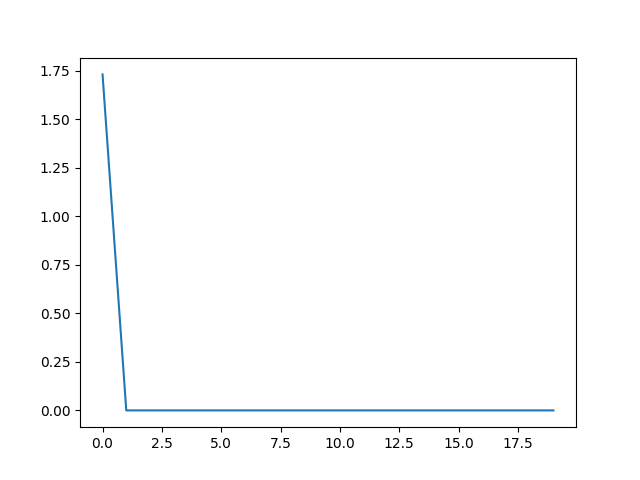

In [43]:
obj = torch.ones((3,)).requires_grad_()

def loss(sth):
    return torch.linalg.norm(sth)

losses = []

opt = torch.optim.Rprop([obj], lr=1,)
for i in range(20):
    def closure():
        opt.zero_grad()
        l = loss(obj)
        l.backward()
        losses.append(float(l))
        return l
    opt.step(closure)
print(loss(obj))
fig, axes = plt.subplots()
axes.plot(losses)

Adafactor tensor(1.0910e-05, grad_fn=<LinalgVectorNormBackward0>)
Adagrad tensor(0., grad_fn=<LinalgVectorNormBackward0>)
RMSprop tensor(0., grad_fn=<LinalgVectorNormBackward0>)
Rprop tensor(1.7292e-06, grad_fn=<LinalgVectorNormBackward0>)

In [44]:
torch.meshgrid(torch.arange(end=3), torch.arange(end=4), indexing='ij')

(tensor([[0, 0, 0, 0],
         [1, 1, 1, 1],
         [2, 2, 2, 2]]),
 tensor([[0, 1, 2, 3],
         [0, 1, 2, 3],
         [0, 1, 2, 3]]))

In [45]:
np.mgrid[:3, :4]

array([[[0, 0, 0, 0],
        [1, 1, 1, 1],
        [2, 2, 2, 2]],

       [[0, 1, 2, 3],
        [0, 1, 2, 3],
        [0, 1, 2, 3]]])

## Take-away

* Try to not limit architecture to linear functions and ray transfer matrices, but generalized transfer functions
* Both forward and backward propagation desirable, at least for ray positions.
* Pure functions, inspired by functional programming, work well here
  * Make sure the model cannot have an invalid or inconsistent state -- issue with current TemGym!
  * 1:1 mapping between model and model parameters desirable
  * Creating a model SHOULD be cheap compared to propagating many rays, so we can just create new models instead of modifying existing ones. That makes it easier to ensure models are consistent with their parameters.
* Not only ray propagation, but also solver to find rays with certain properties! Here, for each detector pixel find a ray that goes through the focus point.
  * Make model invertible. For linear functions, `np.linalg.inv()` does the trick, but more generally one should probably use pytorch or sth like this. Here, use "minimize" as a stand-in, but pytorch would be WAY more powerful and faster since it can auto-differentiate.
* Try to generalize and re-use functions, in particular the ones doing coordinate transformations
